<a href="https://colab.research.google.com/github/Linaqruf/sdxl-model-converter/blob/main/sdxl_model_converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![visitor][visitor-badge]][visitor-stats]
<!-- [![ko-fi][ko-fi-badge]][ko-fi-link] -->

# **SDXL Model Converter**
A Colab Notebook To Convert SDXL Checkpoint to Diffusers format

[visitor-badge]: https://api.visitorbadge.io/api/visitors?path=SDXL%20Model%20Converter&label=Visitors&labelColor=%2334495E&countColor=%231ABC9C&style=flat&labelStyle=none
[visitor-stats]: https://visitorbadge.io/status?path=SDXL%20Model%20Converter
[ko-fi-badge]: https://img.shields.io/badge/Support%20me%20on%20Ko--fi-F16061?logo=ko-fi&logoColor=white&style=flat
[ko-fi-link]: https://ko-fi.com/linaqruf

| Notebook Name | Description | Link |
| --- | --- | --- |
| [Kohya LoRA Trainer XL](https://github.com/Linaqruf/kohya-trainer/blob/main/kohya-LoRA-trainer-XL.ipynb) | LoRA Training | [![](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&labelColor=5c5c5c&color=0f80c1&label=%20&style=flat)](https://colab.research.google.com/github/Linaqruf/kohya-trainer/blob/main/kohya-LoRA-trainer-XL.ipynb) |
| [Kohya Trainer XL](https://github.com/Linaqruf/kohya-trainer/blob/main/kohya-trainer-XL.ipynb) | Native Training | [![](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&labelColor=5c5c5c&color=0f80c1&label=%20&style=flat)](https://colab.research.google.com/github/Linaqruf/kohya-trainer/blob/main/kohya-trainer-XL.ipynb) |


In [ ]:
#@title ## **Install Kohya Script**
import os
from subprocess import getoutput

# Directories
root_dir = "/content"
repo_dir = os.path.join(root_dir, "kohya-trainer")
models_dir = os.path.join(root_dir, "models")
tools_dir = os.path.join(repo_dir, "tools")
vae_dir = os.path.join(root_dir, "vae")

# Repository details
repo_url = "https://github.com/kohya-ss/sd-scripts" #@param {type:"string"}
branch = "sdxl" #@param {type:"string"}

def clone_repo(url, dir, branch):
    if not os.path.exists(dir):
       !git clone -b {branch} {url} {dir}

def setup_directories(dirs):
    for dir in dirs:
        os.makedirs(dir, exist_ok=True)

def install_dependencies():
    t4_xformers_wheel = "https://github.com/Linaqruf/colab-xformers/releases/download/0.0.20/xformers-0.0.20+1d635e1.d20230519-cp310-cp310-linux_x86_64.whl"
    gpu_info = getoutput('nvidia-smi')
    !apt install aria2
    !pip install -q --upgrade diffusers[torch]==0.18.2 transformers==4.30.2 einops==0.6.0 open-clip-torch==2.20.0 invisible-watermark -e .
    !pip install -q xformers==0.0.20

def prepare_environment():
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    os.environ["SAFETENSORS_FAST_GPU"] = "1"
    os.environ["PYTHONWARNINGS"] = "ignore"
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:512"
    os.environ["TCMALLOC_AGGRESSIVE_DECOMMIT"] = "t"
    os.environ["CUDA_MODULE_LOADING"] = "LAZY"

def main():
    os.chdir(root_dir)
    clone_repo(repo_url, repo_dir, branch)
    os.chdir(repo_dir)
    setup_directories([repo_dir, models_dir, tools_dir, vae_dir])
    install_dependencies()
    prepare_environment()

main()

In [ ]:
# @title ## **Download SDXL**
import os
import re
import json
import glob
import gdown
import requests
import subprocess
from urllib.parse import urlparse, unquote
from pathlib import Path

os.chdir(root_dir)

# @markdown Place your Huggingface [Read Token](https://huggingface.co/settings/tokens) Here.

HUGGINGFACE_TOKEN = ""#@param {type: "string"}
SDXL_MODEL_URL = "https://civitai.com/api/download/models/128439" #@param {type: "string"}

def get_supported_extensions():
    return tuple([".ckpt", ".safetensors", ".pt", ".pth"])

def get_filename(url):
    extensions = get_supported_extensions()

    if url.endswith(tuple(extensions)):
        filename = os.path.basename(url)
    else:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        if 'content-disposition' in response.headers:
            content_disposition = response.headers['content-disposition']
            filename = re.findall('filename="?([^"]+)"?', content_disposition)[0]
        else:
            url_path = urlparse(url).path
            filename = unquote(os.path.basename(url_path))

    if filename.endswith(tuple(get_supported_extensions())):
        return filename
    else:
        return None

def parse_args(config):
    args = []

    for k, v in config.items():
        if k.startswith("_"):
            args.append(f"{v}")
        elif isinstance(v, str) and v is not None:
            args.append(f'--{k}={v}')
        elif isinstance(v, bool) and v:
            args.append(f"--{k}")
        elif isinstance(v, float) and not isinstance(v, bool):
            args.append(f"--{k}={v}")
        elif isinstance(v, int) and not isinstance(v, bool):
            args.append(f"--{k}={v}")

    return args

def aria2_download(dir, filename, url):
    user_header = f"Authorization: Bearer {HUGGINGFACE_TOKEN}"

    aria2_config = {
        "console-log-level"         : "error",
        "summary-interval"          : 10,
        "header"                    : user_header if "huggingface.co" in url else None,
        "continue"                  : True,
        "max-connection-per-server" : 16,
        "min-split-size"            : "1M",
        "split"                     : 16,
        "dir"                       : dir,
        "out"                       : filename,
        "_url"                      : url,
    }
    aria2_args = parse_args(aria2_config)
    subprocess.run(["aria2c", *aria2_args])

def gdown_download(url, dst, filepath):
    if "/uc?id/" in url or "/file/d/" in url:
        return gdown.download(url, filepath, quiet=False)
    elif "/drive/folders/" in url:
        os.chdir(dst)
        return gdown.download_folder(url, quiet=True, use_cookies=False)

def download(url, dst):
    filename = get_filename(url)
    filepath = os.path.join(dst, filename)

    if "drive.google.com" in url:
        gdown = gdown_download(url, dst, filepath)
    elif url.startswith("/content/drive/MyDrive/"):
        return url
    else:
        if "huggingface.co" in url:
            if "/blob/" in url:
                url = url.replace("/blob/", "/resolve/")
        aria2_download(dst, filename, url)

def main():
    model_path = SDXL_MODEL_URL
    download(model_path, models_dir)
    print(f"Model downloaded at: {model_path}")

main()

In [ ]:
#@title ## **Convert SDXL to Diffusers**
import os
import urllib.request

os.chdir(root_dir)
#@markdown ### **Conversion Config**
model_to_load = "/content/models/counterfeitxl_.safetensors" #@param {'type': 'string'}
global_step = 0
epoch = 0
save_precision_as = "fp16" #@param ["fp16","bf16","float"] {'allow-input': false}
reference_model = "stabilityai/stable-diffusion-xl-base-1.0"

def convert_dict(config):
    args = ""
    for k, v in config.items():
        if k.startswith("_"):
            args += f'"{v}" '
        elif isinstance(v, str):
            args += f'--{k}="{v}" '
        elif isinstance(v, bool) and v:
            args += f"--{k} "
        elif isinstance(v, float) and not isinstance(v, bool):
            args += f"--{k}={v} "
        elif isinstance(v, int) and not isinstance(v, bool):
            args += f"--{k}={v} "
    return args

def check_and_download_script(script_name, script_url):
    if not os.path.exists(script_name):
        print(f"{script_name} not found, downloading...")
        urllib.request.urlretrieve(script_url, script_name)

def run_script(script_name, script_args):
    !python {script_name} {script_args}

def main():
    script_name = "convert_sdxl_to_diffusers.py"
    script_url = "https://raw.githubusercontent.com/Linaqruf/sdxl-model-converter/main/convert_sdxl_to_diffusers.py"
    check_and_download_script(script_name, script_url)

    config = {
        "model_to_load": model_to_load,
        "save_precision_as": save_precision_as,
        "epoch": epoch,
        "global_step": global_step,
        "reference_model": reference_model,
    }
    run_script(script_name, convert_dict(config))

main()


## **Inference**


### **Run pipeline**

In [ ]:
import torch
from torch import autocast
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionXLPipeline, EulerAncestralDiscreteScheduler

model = "/content/models/counterfeitxl_"
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae")

pipe = StableDiffusionXLPipeline.from_pretrained(
    model,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    vae=vae
    )
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.to('cuda')


### **Generate**

  0%|          | 0/50 [00:00<?, ?it/s]

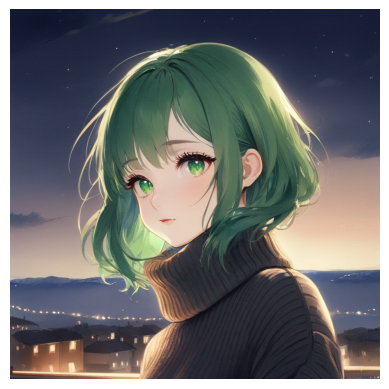

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

prompt = "masterpiece, best quality, 1girl, green hair, sweater, looking at viewer, upper body, beanie, outdoors, watercolor, night, turtleneck"
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output = "/content/anime_girl.png"

image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    width=1024,
    height=1024,
    guidance_scale=12,
    target_size=(1024,1024),
    original_size=(4096,4096),
    num_inference_steps=50
    ).images[0]

image.save(output)
image = Image.open(output)
plt.imshow(image)
plt.axis('off') # to hide the axis
plt.show()


### **Clear Memory**

In [ ]:
import gc

if "pipe" in globals():
    del pipe
if "image" in globals():
    del image
torch.cuda.empty_cache()
gc.collect()

## **Deploy**

In [ ]:
# @title ### **Huggingface Hub config**
from huggingface_hub import login, HfApi
from huggingface_hub.utils import validate_repo_id, HfHubHTTPError

# @markdown Login to Huggingface Hub
# @markdown > Get **your** huggingface `WRITE` token [here](https://huggingface.co/settings/tokens)
write_token = ""  # @param {type:"string"}
# @markdown Fill this if you want to upload to your organization, or just leave it empty.
orgs_name = ""  # @param{type:"string"}
# @markdown If your model repo does not exist, it will automatically create it.
model_name = ""  # @param {type:"string"}
make_private = False  # @param{type:"boolean"}

def authenticate(write_token):
    login(write_token, add_to_git_credential=True)
    api = HfApi()
    return api.whoami(write_token), api

def create_model_repo(api, user, orgs_name, model_name, make_private=False):
    if orgs_name == "":
        repo_id = user["name"] + "/" + model_name.strip()
    else:
        repo_id = orgs_name + "/" + model_name.strip()

    try:
        validate_repo_id(repo_id)
        api.create_repo(repo_id=repo_id, repo_type="model", private=make_private)
        print(f"Model repo '{repo_id}' didn't exist, creating repo")
    except HfHubHTTPError as e:
        print(f"Model repo '{repo_id}' exists, skipping create repo")

    print(f"Model repo '{repo_id}' link: https://huggingface.co/{repo_id}\n")

    return repo_id

user, api = authenticate(write_token)

if model_name:
    model_repo = create_model_repo(api, user, orgs_name, model_name, make_private)


In [ ]:
# @title ### **Upload to Huggingface**
from huggingface_hub import HfApi
from pathlib import Path
import os

api = HfApi()

# @markdown This will be uploaded to model repo
model_path = "/content/models/counterfeitxl_"  # @param {type :"string"}
path_in_repo = ""  # @param {type :"string"}
project_name = os.path.basename(model_path)

# @markdown Other Information
commit_message = ""  # @param {type :"string"}

def is_diffusers_model(model_path):
    required_folders = {"unet", "text_encoder", "text_encoder_2", "tokenizer", "tokenizer_2", "scheduler", "vae"}
    return required_folders.issubset(set(os.listdir(model_path))) and os.path.isfile(os.path.join(model_path, "model_index.json"))

def upload_model(model_paths, is_folder: bool):
    path_obj = Path(model_paths)
    trained_model = path_obj.parts[-1]

    if path_in_repo:
        trained_model = path_in_repo

    if is_folder:
        notification = f"Uploading {trained_model} from {model_paths} to https://huggingface.co/{model_repo}"
        print(notification)

        if is_diffusers_model(model_paths):
            commit_message = f"Upload diffusers format: {trained_model}"
            print("Detected diffusers model. Adjusting upload parameters.")
        else:
            commit_message = f"Upload checkpoint: {trained_model}"
            print("Detected regular model. Adjusting upload parameters.")

        api.upload_folder(
            folder_path=model_paths,
            path_in_repo=trained_model,
            repo_id=model_repo,
            commit_message=commit_message,
            ignore_patterns=".ipynb_checkpoints",
        )

        success_notification = f"Upload successful. Check the model at https://huggingface.co/{model_repo}/tree/main"
        print(success_notification)

    else:
        notification = f"Uploading {trained_model} from {model_paths} to https://huggingface.co/{model_repo}"
        print(notification)

        commit_message = f"Upload file: {trained_model}"

        api.upload_file(
            path_or_fileobj=model_paths,
            path_in_repo=trained_model,
            repo_id=model_repo,
            commit_message=commit_message,
        )

        success_notification = f"Upload successful. Check the file at https://huggingface.co/{model_repo}/blob/main/{trained_model}"
        print(success_notification)

def upload():
    if model_path.endswith((".ckpt", ".safetensors", ".pt")):
        upload_model(model_path, False)
    else:
        upload_model(model_path, True)

upload()
